## Totalt nedbørsmengde per år


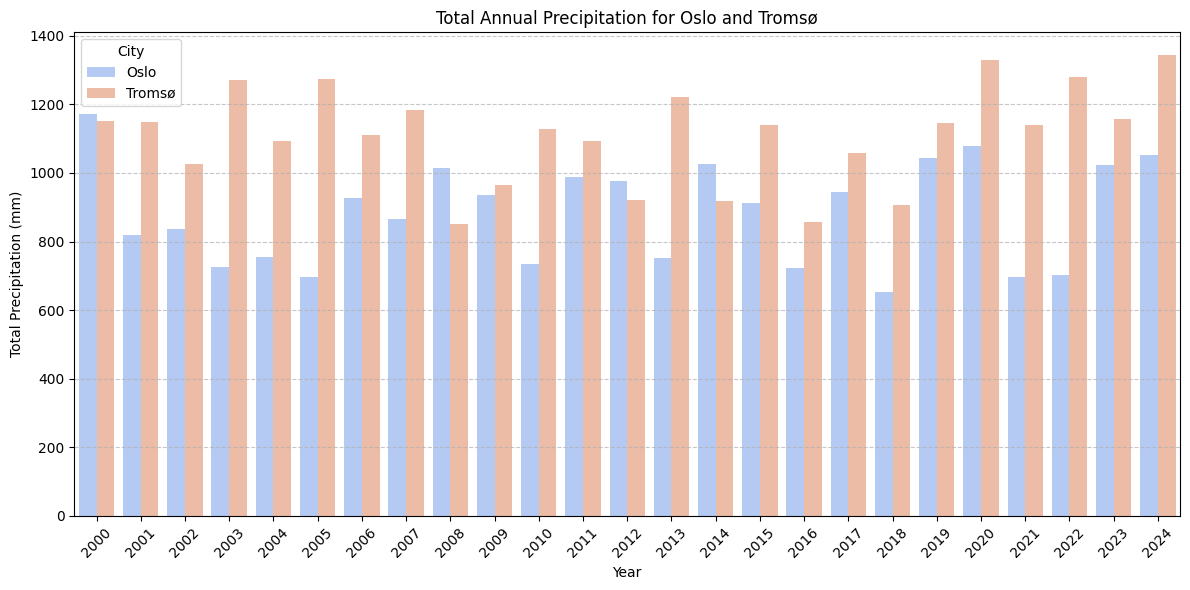

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filstier til dataene
oslo_csv = "../../data/processed/vaerdata_oslo.csv"
tromso_csv = "../../data/processed/vaerdata_tromso.csv"

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)

# Filtrerer dataene for nedbør (precipitation) og lager eksplisitte kopier
df_oslo_precipitation = df_oslo[
    (df_oslo['elementId'] == 'sum(precipitation_amount P1D)') & 
    (df_oslo['timeOffset'] == 'PT18H')
].copy()
df_tromso_precipitation = df_tromso[
    (df_tromso['elementId'] == 'sum(precipitation_amount P1D)') & 
    (df_tromso['timeOffset'] == 'PT18H')
].copy()

# Konverterer 'referenceTime' til datetime for korrekt gruppering
df_oslo_precipitation['referenceTime'] = pd.to_datetime(df_oslo_precipitation['referenceTime'])
df_tromso_precipitation['referenceTime'] = pd.to_datetime(df_tromso_precipitation['referenceTime'])

# Legger til en kolonne for år
df_oslo_precipitation['year'] = df_oslo_precipitation['referenceTime'].dt.year
df_tromso_precipitation['year'] = df_tromso_precipitation['referenceTime'].dt.year

# Summerer nedbørsmengden per år
annual_oslo_precipitation = df_oslo_precipitation.groupby('year')['value'].sum().reset_index()
annual_tromso_precipitation = df_tromso_precipitation.groupby('year')['value'].sum().reset_index()

# Legger til en kolonne for by
annual_oslo_precipitation['city'] = 'Oslo'
annual_tromso_precipitation['city'] = 'Tromsø'

# Kombinerer dataene for Oslo og Tromsø
annual_precipitation = pd.concat([annual_oslo_precipitation, annual_tromso_precipitation])

# Visualiserer dataene med Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=annual_precipitation, x='year', y='value', hue='city', palette='coolwarm')

# Legger til tittel og akseetiketter
plt.title('Total Annual Precipitation for Oslo and Tromsø')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
plt.xticks(rotation=45)
plt.legend(title='City')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Viser grafen
plt.tight_layout()
plt.show()

## Tempratur forskjell by

In [3]:
'''Ikke fått lagt in Range-funksjonen her'''

from dash import Dash, dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import calendar

# Filstier til dataene
oslo_csv = "../../data/processed/vaerdata_oslo.csv"
tromso_csv = "../../data/processed/vaerdata_tromso.csv"

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)


# Opprett Dash-applikasjonen
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Temperature Difference Comparison"),
    html.Label("City:"),
    dcc.Dropdown(
        id='city-dropdown',
        options=[
            {'label': 'Oslo', 'value': 'Oslo'},
            {'label': 'Tromsø', 'value': 'Tromsø'}
        ],
        value='Oslo'
    ),
    html.Label("Month:"),
    dcc.Dropdown(
        id='month-dropdown',
        options=[{'label': month, 'value': month} for month in calendar.month_name[1:]],
        value='January'
    ),
    html.Label("Start Year:"),
    dcc.Input(id='start-year', type='number', value=2000, min=2000, max=2023),
    html.Label("End Year:"),
    dcc.Input(id='end-year', type='number', value=2023, min=2000, max=2023),
    dcc.Graph(id='temperature-graph')
])

@app.callback(
    Output('temperature-graph', 'figure'),
    Input('city-dropdown', 'value'),
    Input('month-dropdown', 'value'),
    Input('start-year', 'value'),
    Input('end-year', 'value')
)
def update_graph(city, month, start_year, end_year):
    if city == "Oslo":
        df_filtered = df_oslo_avg[(df_oslo_avg['year'] >= start_year) & 
                                  (df_oslo_avg['year'] <= end_year) & 
                                  (df_oslo_avg['month'] == month)]
    elif city == "Tromsø":
        df_filtered = df_tromso_avg[(df_tromso_avg['year'] >= start_year) & 
                                    (df_tromso_avg['year'] <= end_year) & 
                                    (df_tromso_avg['month'] == month)]
    else:
        return px.bar(title="No Data Available")
    
    # Oppdater grafen med farger basert på temperaturforskjell
    fig = px.bar(
        df_filtered,
        x='year',
        y='temp_diff',
        color='temp_diff',  # Farge basert på temperaturforskjell
        color_continuous_scale='YlOrRd',  # Gult til rødt fargeskjema
        title=f'Average Daily Temperature Difference for {month} - {city} ({start_year} to {end_year})',
        labels={"temp_diff": "Temperature Difference (°C)", "year": "Year"}
    )
    return fig

if __name__ == '__main__':
    app.run(debug=True)

[2025-04-18 17:38:39,370] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/ThomasKonglevoll/Desktop/Miljodataanalyseapplikasjon/.venv/lib/python3.13/site-packages/flask/app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/ThomasKonglevoll/Desktop/Miljodataanalyseapplikasjon/.venv/lib/python3.13/site-packages/flask/app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/ThomasKonglevoll/Desktop/Miljodataanalyseapplikasjon/.venv/lib/python3.13/site-packages/dash/dash.py", line 1413, in dispatch
    ctx.run(
    ~~~~~~~^
        functools.partial(
        ^^^^^^^^^^^^^^^^^^
    ...<7 lines>...
        )
        ^
    )
    ^
  File "/Users/ThomasKonglevoll/Desktop/Miljodataanalyseapplikasjon/.venv/lib/python3.13/

## Manglende verdier

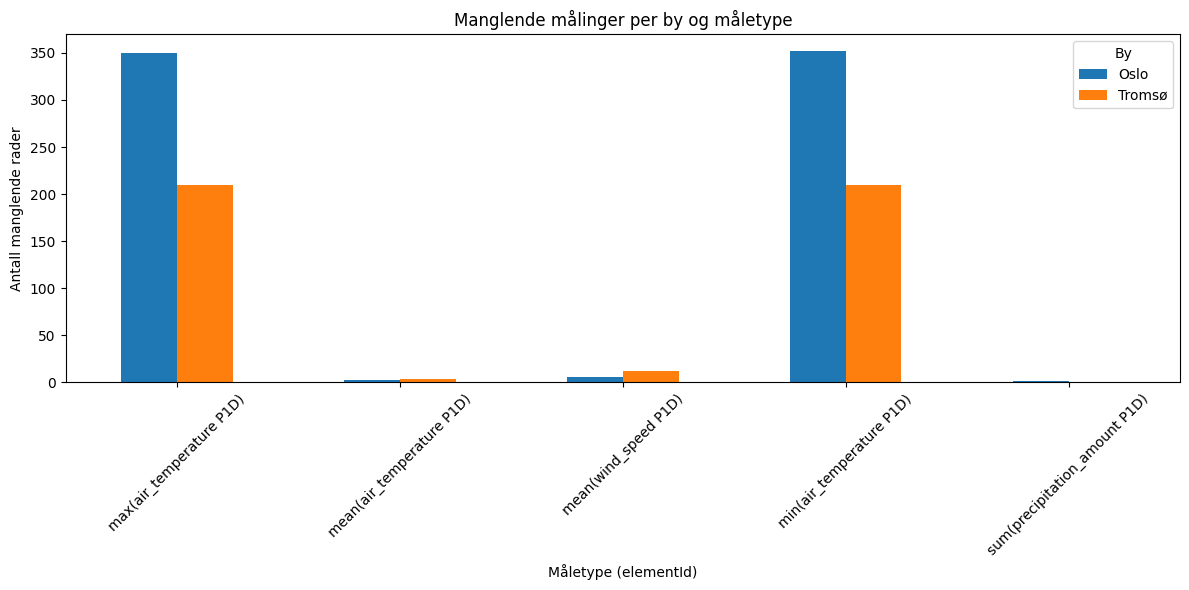

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Les inn data
df = pd.read_csv("../../data/missing/missing_in_both.csv")

# 2. Fjern eventuelle whitespaces i kolonnenavn og innhold
df.columns = df.columns.str.strip()
df['city'] = df['city'].astype(str).str.strip()
df['elementId'] = df['elementId'].astype(str).str.strip()

# 3. Filtrer kun rader med manglende data (dvs. hvor city er satt)
missing_data = df[df['city'].notna() & (df['city'] != '')]

# 4. Gruppér og tell hvor mange ganger hver by mangler en type måling
summary = missing_data.groupby(['city', 'elementId']).size().reset_index(name='count')

# 5. Pivotér for visualisering
pivoted = summary.pivot(index='elementId', columns='city', values='count').fillna(0)

# 6. Plot
pivoted.plot(kind='bar', figsize=(12, 6))
plt.title('Manglende målinger per by og måletype')
plt.xlabel('Måletype (elementId)')
plt.ylabel('Antall manglende rader')
plt.xticks(rotation=45)
plt.legend(title='By')
plt.tight_layout()
plt.show()


## Interaktiv versjon av manglende data

### Denne er litt incomplete, men tanken er at man skal de opp mot hverandre, bare interaktiv slik som den over

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- 1. Last inn og filtrér manglende verdier ---
df = pd.read_csv("../../data/missing/missing_in_both.csv")

# Konverter 'date'-kolonnen til datetime-format og dropp ugyldige
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Gjelder kun rader hvor verdien faktisk mangler
missing = df[
    ((df['city'] == 'Oslo') & (df['oslo_value'].isna())) |
    ((df['city'] == 'Tromsø') & (df['tromso_value'].isna()))
].copy()

# --- 2. Lag widgets ---
city_dropdown = widgets.Dropdown(
    options=['Oslo', 'Tromsø', 'Begge'],
    value='Oslo',
    description='By:'
)

element_dropdown = widgets.Dropdown(
    options=sorted(missing['elementId'].unique()),
    value=sorted(missing['elementId'].unique())[0],
    description='Element:'
)

date_slider = widgets.SelectionSlider(
    options=sorted(missing['date'].dt.date.unique()),
    description='Fra dato:',
    continuous_update=False,
    value=sorted(missing['date'].dt.date.unique())[0],
    orientation='horizontal'
)

# --- 3. Oppdateringsfunksjon ---
def update_plot(city, elementId, from_date):
    clear_output(wait=True)
    display(city_dropdown, element_dropdown, date_slider)
    
    filtered = missing[
        (missing['elementId'] == elementId) &
        (missing['date'].dt.date >= from_date)
    ]
    
    if city != 'Begge':
        filtered = filtered[filtered['city'] == city]
    
    # Gruppér etter dato og by, tell rader
    counts = filtered.groupby(['date', 'city']).size().reset_index(name='count')
    
    # Plott
    fig, ax = plt.subplots(figsize=(10, 5))
    for city_name in counts['city'].unique():
        subset = counts[counts['city'] == city_name]
        ax.plot(subset['date'], subset['count'], label=city_name)
    
    ax.set_title(f"Manglende data: {elementId}")
    ax.set_xlabel("Dato")
    ax.set_ylabel("Antall manglende datapunkter")
    ax.legend()
    plt.tight_layout()
    plt.show()

# --- 4. Koble widgets til funksjon ---
ui = widgets.VBox([city_dropdown, element_dropdown, date_slider])
out = widgets.interactive_output(update_plot, {
    'city': city_dropdown,
    'elementId': element_dropdown,
    'from_date': date_slider
})

display(ui, out)


Output()

## Gjennomsnittlig vindhastighet per måned

In [6]:
import pandas as pd
import plotly.graph_objects as go

# Filstier til dataene
oslo_csv = "../../data/processed/vaerdata_oslo.csv"
tromso_csv = "../../data/processed/vaerdata_tromso.csv"

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)

# Konverter 'referenceTime' til datetime-format og fjern tidssoneinformasjon
df_oslo['referenceTime'] = pd.to_datetime(df_oslo['referenceTime']).dt.tz_localize(None)
df_tromso['referenceTime'] = pd.to_datetime(df_tromso['referenceTime']).dt.tz_localize(None)

# Filtrer dataene for 'mean(wind_speed P1D)' og lag kopier
df_oslo_wind = df_oslo[df_oslo['elementId'] == 'mean(wind_speed P1D)'].copy()
df_tromso_wind = df_tromso[df_tromso['elementId'] == 'mean(wind_speed P1D)'].copy()

# Legg til kolonner for år og måned
df_oslo_wind['year_month'] = df_oslo_wind['referenceTime'].dt.to_period('M')
df_tromso_wind['year_month'] = df_tromso_wind['referenceTime'].dt.to_period('M')

# Beregn gjennomsnittlig vindhastighet per måned
oslo_monthly_avg = df_oslo_wind.groupby('year_month')['value'].mean().reset_index()
tromso_monthly_avg = df_tromso_wind.groupby('year_month')['value'].mean().reset_index()

# Konverter 'year_month' tilbake til datetime for plotting
oslo_monthly_avg['year_month'] = oslo_monthly_avg['year_month'].dt.to_timestamp()
tromso_monthly_avg['year_month'] = tromso_monthly_avg['year_month'].dt.to_timestamp()

# Opprett en figur
fig = go.Figure()

# Legg til punkter og linje for Oslo
fig.add_trace(go.Scatter(
    x=oslo_monthly_avg['year_month'],
    y=oslo_monthly_avg['value'],
    mode='lines+markers',  # Linjer og punkter
    name='Oslo',
    line=dict(color='blue'),  # Valgfri farge for Oslo
    marker=dict(size=6)  # Størrelse på punktene
))

# Legg til punkter og linje for Tromsø
fig.add_trace(go.Scatter(
    x=tromso_monthly_avg['year_month'],
    y=tromso_monthly_avg['value'],
    mode='lines+markers',  # Linjer og punkter
    name='Tromsø',
    line=dict(color='red'),  # Valgfri farge for Tromsø
    marker=dict(size=6)  # Størrelse på punktene
))

# Oppdater layout
fig.update_layout(
    title='Gjennomsnittlig vindhastighet per måned i Oslo og Tromsø',
    xaxis_title='Tid',
    yaxis_title='Vindhastighet (m/s)',
    template='plotly_white',  # Valgfritt: lys bakgrunn
    xaxis=dict(showgrid=True),  # Viser rutenett på x-aksen
    yaxis=dict(showgrid=True)   # Viser rutenett på y-aksen
)

# Vis figuren
fig.show()

## Antall sommerdager per år

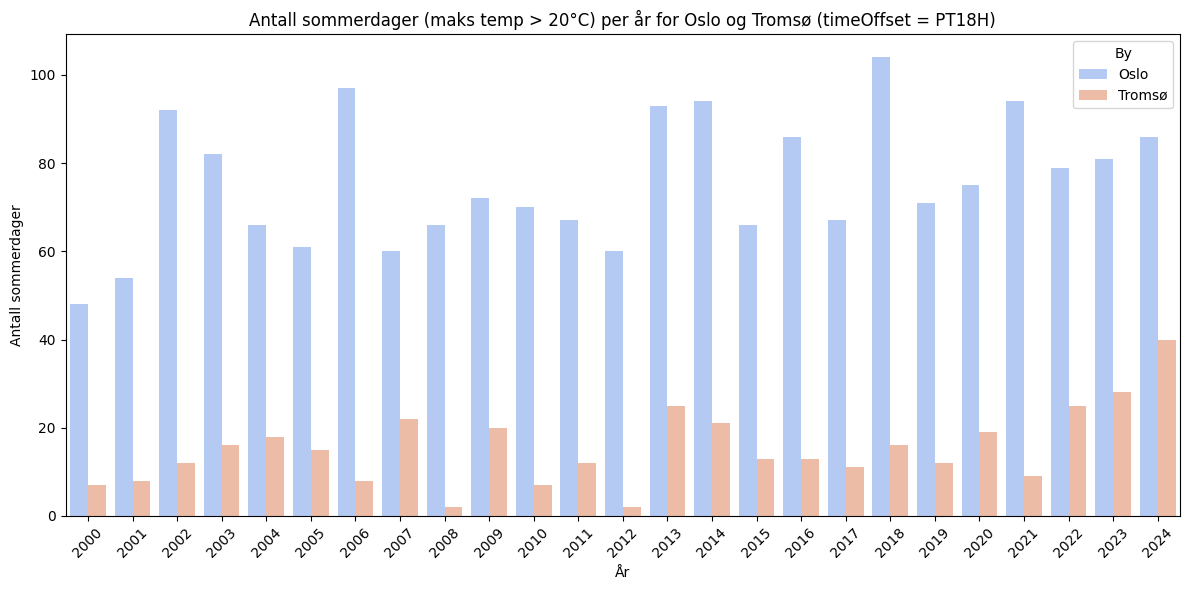

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filstier til dataene
oslo_csv = "../../data/processed/vaerdata_oslo.csv"
tromso_csv = "../../data/processed/vaerdata_tromso.csv"

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)

# Konverter 'referenceTime' til datetime-format
df_oslo['referenceTime'] = pd.to_datetime(df_oslo['referenceTime'])
df_tromso['referenceTime'] = pd.to_datetime(df_tromso['referenceTime'])

# Legg til kolonner for år og dag
df_oslo['year'] = df_oslo['referenceTime'].dt.year
df_oslo['day'] = df_oslo['referenceTime'].dt.date
df_tromso['year'] = df_tromso['referenceTime'].dt.year
df_tromso['day'] = df_tromso['referenceTime'].dt.date

# Filtrer dataene for maks temperatur med timeOffset = PT18H for Oslo og Tromsø
df_oslo_max = df_oslo[(df_oslo["elementId"] == "max(air_temperature P1D)") & (df_oslo["timeOffset"] == "PT18H")][["day", "year", "value"]].rename(columns={"value": "temp_max"})
df_tromso_max = df_tromso[(df_tromso["elementId"] == "max(air_temperature P1D)") & (df_tromso["timeOffset"] == "PT18H")][["day", "year", "value"]].rename(columns={"value": "temp_max"})

# Filtrer ut sommerdager (dager med maks temperatur over 20 grader)
df_oslo_sommerdager = df_oslo_max[df_oslo_max["temp_max"] > 20]
df_tromso_sommerdager = df_tromso_max[df_tromso_max["temp_max"] > 20]

# Tell antall sommerdager per år for hver by
oslo_sommerdager_per_år = df_oslo_sommerdager.groupby("year").size().reset_index(name="sommerdager")
tromso_sommerdager_per_år = df_tromso_sommerdager.groupby("year").size().reset_index(name="sommerdager")

# Legg til en kolonne for by
oslo_sommerdager_per_år["by"] = "Oslo"
tromso_sommerdager_per_år["by"] = "Tromsø"

# Kombiner dataene for begge byene
sommerdager_per_år = pd.concat([oslo_sommerdager_per_år, tromso_sommerdager_per_år])

# Visualiser dataene med Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=sommerdager_per_år, x="year", y="sommerdager", hue="by", palette="coolwarm")
plt.title("Antall sommerdager (maks temp > 20°C) per år for Oslo og Tromsø (timeOffset = PT18H)")
plt.xlabel("År")
plt.ylabel("Antall sommerdager")
plt.xticks(rotation=45)
plt.legend(title="By")
plt.tight_layout()
plt.show()